In [1]:
import os
import cv2
import json
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from PIL import Image
from datetime import datetime as dt

In [2]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import mobilenet_v3
from tensorflow.keras.layers import Dense,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adadelta
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from tensorflow.python.client import device_lib
tf.test.is_built_with_cuda()
print("Num GPUs Available: ", len(device_lib.list_local_devices()))

Num GPUs Available:  2


In [4]:
IMG_SIZE = 224
batch_size=None

In [5]:
%%time
ds_train=tf.keras.preprocessing.image_dataset_from_directory("D:\\ECG DB\\FourClasseswith 20percent",
                                                             labels='inferred',label_mode="int",
                                                             class_names=['AF','NSR','PAC','PVC'],color_mode='rgb',
                                                             image_size=(IMG_SIZE,IMG_SIZE), #reshapeauto
                                                             shuffle=True,seed=123,validation_split=0.4,subset="training")

Found 2390 files belonging to 4 classes.
Using 1434 files for training.
CPU times: total: 141 ms
Wall time: 161 ms


In [6]:
%%time
ds_validate=tf.keras.preprocessing.image_dataset_from_directory("D:\\ECG DB\\FourClasseswith 20percent",
                                                                labels='inferred',label_mode="int",
                                                                class_names=['AF','NSR','PAC','PVC'],color_mode='rgb',
                                                                image_size=(IMG_SIZE,IMG_SIZE), #reshapeauto
                                                                shuffle=True,seed=123,validation_split=0.4,subset="validation")

Found 2390 files belonging to 4 classes.
Using 956 files for validation.
CPU times: total: 93.8 ms
Wall time: 103 ms


In [7]:
class_names = ds_train.class_names
print(class_names)

['AF', 'NSR', 'PAC', 'PVC']


(32, 224, 224, 3)
(32,)


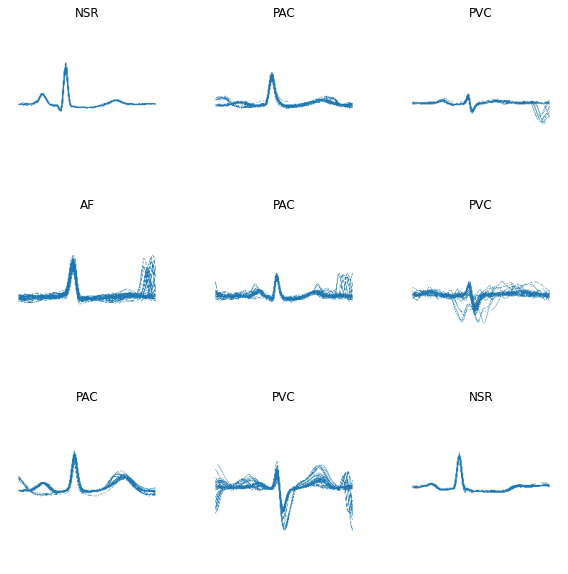

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
for image_batch, labels_batch in ds_train:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [9]:
%%time
val_batches = tf.data.experimental.cardinality(ds_validate)
validation_dataset = ds_validate.skip(val_batches //2)
test_dataset = ds_validate.take(val_batches //2)

CPU times: total: 0 ns
Wall time: 9.71 ms


In [10]:
test_dataset

<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>

In [11]:
%%time
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 15
Number of test batches: 15
CPU times: total: 0 ns
Wall time: 999 µs


In [12]:
%%time
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = ds_train.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

CPU times: total: 15.6 ms
Wall time: 14 ms


In [13]:
#data_augmentation = tf.keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomZoom(.5,.5),])

In [14]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./223.5, offset=-1)

In [14]:
# Create the base model from the pre-trained model MV3
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                                    include_top=False,
                                                    weights='imagenet')

In [15]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [16]:
base_model.trainable = False #Freeze the convolutional base

In [17]:
# Let's take a look at the base model architecture
base_model.summary()
len(base_model.layers)

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

154

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

In [19]:
number_of_classes = 4
inputs = tf.keras.Input(shape=(224,224, 3))
#x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
      # call it on the given tensor
x = keras.layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
initializer = tf.keras.initializers.GlorotUniform(seed=42)
activation = None  #tf.keras.activations.softmax
outputs =outputs = keras.layers.Dense(number_of_classes,
                             kernel_initializer=initializer,
                             activation=activation,name="predictions")(x) 
mv2 = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.01
mv2.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), # default from_logits=False
              metrics=[keras.metrics.SparseCategoricalAccuracy()])

In [21]:
%%time
first_hist=mv2.fit(train_dataset, validation_data=val_dataset,epochs=100)


Epoch 1/100
45/45 [==============================] - 34s 663ms/step - loss: 0.5697 - sparse_categorical_accuracy: 0.7831 - val_loss: 0.5715 - val_sparse_categorical_accuracy: 0.7626
Epoch 2/100
45/45 [==============================] - 14s 321ms/step - loss: 0.2123 - sparse_categorical_accuracy: 0.9324 - val_loss: 0.3612 - val_sparse_categorical_accuracy: 0.9118
Epoch 3/100
45/45 [==============================] - 14s 314ms/step - loss: 0.1530 - sparse_categorical_accuracy: 0.9533 - val_loss: 0.2656 - val_sparse_categorical_accuracy: 0.9244
Epoch 4/100
45/45 [==============================] - 14s 322ms/step - loss: 0.1122 - sparse_categorical_accuracy: 0.9609 - val_loss: 0.2280 - val_sparse_categorical_accuracy: 0.9286
Epoch 5/100
45/45 [==============================] - 14s 317ms/step - loss: 0.0850 - sparse_categorical_accuracy: 0.9784 - val_loss: 0.1928 - val_sparse_categorical_accuracy: 0.9370
Epoch 6/100
45/45 [==============================] - 14s 314ms/step - loss: 0.0710 - spars

Epoch 46/100
45/45 [==============================] - 14s 304ms/step - loss: 0.0047 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.1059 - val_sparse_categorical_accuracy: 0.9685
Epoch 47/100
45/45 [==============================] - 14s 305ms/step - loss: 0.0046 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.0975 - val_sparse_categorical_accuracy: 0.9727
Epoch 48/100
45/45 [==============================] - 13s 300ms/step - loss: 0.0054 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.1042 - val_sparse_categorical_accuracy: 0.9727
Epoch 49/100
45/45 [==============================] - 13s 301ms/step - loss: 0.0036 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1024 - val_sparse_categorical_accuracy: 0.9727
Epoch 50/100
45/45 [==============================] - 14s 303ms/step - loss: 0.0043 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1036 - val_sparse_categorical_accuracy: 0.9748
Epoch 51/100
45/45 [==============================] - 14s 302ms/step - loss: 0.0036 -

Epoch 91/100
45/45 [==============================] - 15s 324ms/step - loss: 0.0028 - sparse_categorical_accuracy: 0.9993 - val_loss: 0.1527 - val_sparse_categorical_accuracy: 0.9664
Epoch 92/100
45/45 [==============================] - 15s 345ms/step - loss: 0.0015 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1406 - val_sparse_categorical_accuracy: 0.9664
Epoch 93/100
45/45 [==============================] - 16s 364ms/step - loss: 0.0018 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1137 - val_sparse_categorical_accuracy: 0.9685
Epoch 94/100
45/45 [==============================] - 15s 339ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1178 - val_sparse_categorical_accuracy: 0.9706
Epoch 95/100
45/45 [==============================] - 15s 336ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1117 - val_sparse_categorical_accuracy: 0.9727
Epoch 96/100
45/45 [==============================] - 15s 329ms/step - loss: 0.0011 -

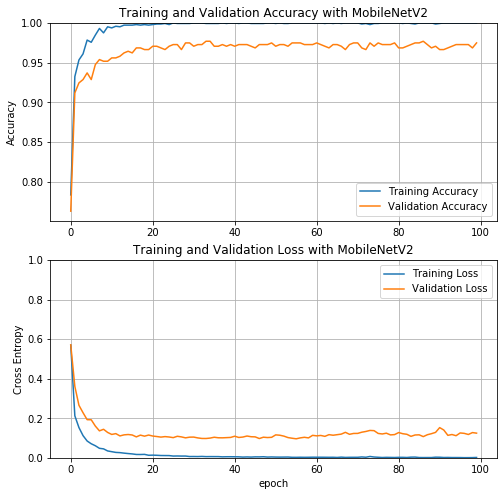

In [22]:
acc = first_hist.history['sparse_categorical_accuracy']
val_acc = first_hist.history['val_sparse_categorical_accuracy']

loss = first_hist.history['loss']
val_loss = first_hist.history['val_loss']

plt.figure(figsize=(8, 8))
plt.style.use('_classic_test_patch')
plt.grid(True)

plt.subplot(2, 1, 1)
plt.style.use('_classic_test_patch')
plt.grid(True)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy with MobileNetV2')

plt.subplot(2, 1, 2)
plt.style.use('_classic_test_patch')
plt.grid(True)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss with MobileNetV2')
plt.xlabel('epoch')
plt.show()

In [23]:
%%time
loss, accuracy= mv2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= mv2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= mv2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy=mv2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= mv2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= mv2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy=mv2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= mv2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy= mv2.evaluate(test_dataset)
print('Test accuracy :', accuracy)
loss, accuracy=mv2.evaluate(test_dataset)
print('Test accuracy :', accuracy)

15/15 [==============================] - 4s 201ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9771
Test accuracy : 0.9770833253860474
15/15 [==============================] - 3s 213ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9771
Test accuracy : 0.9770833253860474
15/15 [==============================] - 4s 235ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9771
Test accuracy : 0.9770833253860474
15/15 [==============================] - 4s 235ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9771
Test accuracy : 0.9770833253860474
15/15 [==============================] - 4s 285ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9771
Test accuracy : 0.9770833253860474
15/15 [==============================] - 6s 379ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9771
Test accuracy : 0.9770833253860474
15/15 [==============================] - 7s 436ms/step - loss: 0.0875 - sparse_categorical_accuracy: 0.9771
Test accuracy : 0.9770833253860474

In [24]:
%%time
export_dir='saved_mv2model/1'
tf.saved_model.save(mv2,export_dir)

converter=tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model=converter.convert()

import pathlib
tflite_model_file=pathlib.Path('saved_mv2model/mv2.tflite')
tflite_model_file.write_bytes(tflite_model)


INFO:tensorflow:Assets written to: saved_mv2model/1\assets
CPU times: total: 30.6 s
Wall time: 31.2 s


8887852

In [28]:
print(test_dataset.as_numpy_iterator().next()[1])

[2 0 1 3 3 3 2 3 3 2 1 1 0 3 3 3 0 3 0 0 0 1 1 2 2 0 1 0 0 0 3 3]


In [25]:
test_dataset = ds_validate.take(val_batches //2)
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = mv2.predict(image_batch)
predictions.shape

(32, 4)

In [26]:
predictions

array([[ 1.5514253e+01, -1.2701930e+01, -1.1468524e+00, -8.0178900e+00],
       [ 8.2111633e-01,  1.2749520e+01, -5.5070972e+00, -1.2014333e+01],
       [ 1.0649041e+01, -5.1882796e+00,  3.9119129e+00, -9.6844835e+00],
       [-8.8270969e+00,  2.2342360e-01,  1.3755716e+01,  3.9333756e+00],
       [-2.2519353e-01, -6.0511446e+00,  6.9979706e+00, -2.8622682e+00],
       [ 1.8263483e+01,  2.1262913e+00, -1.2151598e+01, -1.9965298e+01],
       [ 1.5700849e+00, -7.0150547e+00,  3.9523640e+00,  3.5255580e+00],
       [-6.7411375e+00,  2.5131112e-01,  1.3812305e+01,  1.5698888e+00],
       [-1.2733416e+01,  1.1663089e+00, -7.2647791e+00,  1.0384961e+01],
       [-1.5960159e+00,  1.2725301e+01, -5.7529230e+00, -9.3596268e+00],
       [-8.8450365e+00, -6.8861260e+00, -2.2689471e+00,  1.5839365e+01],
       [-5.1893826e+00, -3.7963448e+00, -2.3544247e+00,  1.0735211e+01],
       [-6.3919840e+00, -8.4288502e+00,  1.7278875e+01, -2.4143496e-01],
       [-1.6841290e+00,  1.6452824e+01, -2.3720510e

In [28]:
np.argmax(predictions[2],axis=0)

0

In [ ]:
predicted_classes=[]
for i in range(100):
    predicted_class=np.argmax(predictions[i])
    predicted_classes.append(predicted_class)

In [ ]:
np.array(predicted_classes)

In [ ]:
label_batch

In [ ]:
# Confusion Matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

y_true=label_batch
y_pred=np.array(predicted_classes)
confusion_matrix(y_true, y_pred)

data = {'y_Actual': y_true,
        'y_Predicted': y_pred
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
print (df)
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
confusion_matrix


In [ ]:
def AF_SandS (conf_matrix):
    TP= conf_matrix[0][0]
    TN= (conf_matrix[1][1]+conf_matrix[2][2]+conf_matrix[3][3]+
               conf_matrix[1][2]+conf_matrix[1][3]+conf_matrix[2][1]+conf_matrix[2][3]+conf_matrix[3][1]+conf_matrix[3][2])
    FP= conf_matrix[0][1]+conf_matrix[0][2]+conf_matrix[0][3]
    FN= conf_matrix[1][0]+conf_matrix[2][0]+conf_matrix[3][0]    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    misclassification = 1- accuracy
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    
    print('-'*50)
    print('AF')
    print(f'Accuracy: {(accuracy)}') 
    print(f'Mis-Classification: {round(misclassification,2)}') 
    print(f'Sensitivity: {(sensitivity)}') 
    print(f'Specificity: {(specificity)}') 

    
def NSR_SandS (conf_matrix):
    TP= conf_matrix[1][1]
    TN= (conf_matrix[0][0]+conf_matrix[2][2]+conf_matrix[3][3]+
               conf_matrix[0][2]+conf_matrix[0][3]+conf_matrix[2][0]+conf_matrix[2][3]+conf_matrix[3][0]+conf_matrix[3][2])
    FP= conf_matrix[1][0]+conf_matrix[1][2]+conf_matrix[1][3]
    FN= conf_matrix[0][1]+conf_matrix[2][1]+conf_matrix[3][1]    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    misclassification = 1- accuracy
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    
    print('-'*50)
    print('NSR')
    print(f'Accuracy: {(accuracy)}') 
    print(f'Mis-Classification: {round(misclassification,2)}') 
    print(f'Sensitivity: {(sensitivity)}') 
    print(f'Specificity: {(specificity)}') 

In [ ]:
def PAC_SandS (conf_matrix):
    TP= conf_matrix[2][2]
    TN= (conf_matrix[0][0]+conf_matrix[1][1]+conf_matrix[3][3]+
               conf_matrix[0][1]+conf_matrix[0][3]+conf_matrix[1][0]+conf_matrix[1][3]+conf_matrix[3][0]+conf_matrix[3][1])
    FP= conf_matrix[2][0]+conf_matrix[2][1]+conf_matrix[2][3]
    FN= conf_matrix[0][2]+conf_matrix[1][2]+conf_matrix[3][2]    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    misclassification = 1- accuracy
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    
    print('-'*50)
    print('PAC')
    print(f'Accuracy: {(accuracy)}') 
    print(f'Mis-Classification: {round(misclassification,2)}') 
    print(f'Sensitivity: {(sensitivity)}') 
    print(f'Specificity: {(specificity)}') 
    
    
def PVC_SandS (conf_matrix):
    TP= conf_matrix[3][3]
    TN= (conf_matrix[0][0]+conf_matrix[1][1]+conf_matrix[2][2]+
               conf_matrix[0][1]+conf_matrix[0][2]+conf_matrix[1][0]+conf_matrix[1][2]+conf_matrix[2][0]+conf_matrix[2][1])
    FP= conf_matrix[3][0]+conf_matrix[3][1]+conf_matrix[3][2]
    FN= conf_matrix[0][3]+conf_matrix[1][3]+conf_matrix[2][3]    
    accuracy = (float (TP+TN) / float(TP + TN + FP + FN))
    misclassification = 1- accuracy
    sensitivity = (TP / float(TP + FN))
    specificity = (TN / float(TN + FP))
    
    print('-'*50)
    print('PVC')
    print(f'Accuracy: {(accuracy)}') 
    print(f'Mis-Classification: {round(misclassification,2)}') 
    print(f'Sensitivity: {(sensitivity)}') 
    print(f'Specificity: {(specificity)}') 

In [ ]:
AF_SandS(confusion_matrix)
NSR_SandS(confusion_matrix)
PAC_SandS(confusion_matrix)
PVC_SandS(confusion_matrix)

In [ ]:
from sklearn.metrics import classification_report
y_true=label_batch
y_pred=np.array(predicted_classes)
target_names = ['AF', 'NSR', 'PAC','PVC']
print(classification_report(y_true, y_pred, target_names=target_names))
